In [1]:
import calendar
import json

import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
from adjustText import adjust_text
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Download dataset from Kaggle (registration required): https://www.kaggle.com/Cornell-University/arxiv/download
filepath = 'arxiv-metadata-oai-snapshot.json'

In [3]:
# The file is made of json objects separated by a line
# This procedure allows us to read only what we need (as opposed to the entire file)
# Set to -1 if you want to read the entire file
max_lines = -1

lines = []
with open(filepath) as file:
    i = 0
    while max_lines < 0 or i < max_lines:
        line = file.readline()
        if not line:
            break
        lines.append(json.loads(line))
        i += 1

print("Read %s publications." % len(lines))

Read 1796911 publications.


In [4]:
# The data can be stored in a dataframe right away
df = pd.DataFrame(lines).set_index("id")
df.update_date = pd.to_datetime(df.update_date, infer_datetime_format=True)
df.head(3)

,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
id,,,,,,,,,,,,,
0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"


In [5]:
# Group by a 30-day window (which models a month)
grouper_month = pd.Grouper(key="update_date", freq="30D")
# Group by year
grouper_year = pd.Grouper(key="update_date", freq="Y")

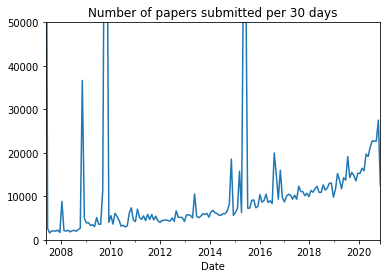

In [6]:
df.groupby(grouper_month).title.count().plot(legend=None)
plt.ylim(bottom=0, top=50000)
plt.title("Number of papers submitted per 30 days")
plt.xlabel("Date")
plt.show()

In [7]:
# We selected some specialized categories(quant-ph, astro-ph, hep-ph, hep-th,cond-mat) and general categories(cs, physics and math) based on their frequencies
selected_categories = [
    ("quant-ph", "maroon", "Quantum Physics"),
    ("astro-ph", "darksalmon", "Astrophysics"),
    ("hep-ph", "orchid", "High Energy Physics Phenomenology"),
    ("hep-th", "darkmagenta", "High Energy Physics Theory"),
    ("cond-mat", "yellow", "Condensed Matter Physics"),
    ("physics", "red", "General Physics"),
    ("cs", "blue", "Computer Science"),
    ("math", "green", "Mathematics")
]

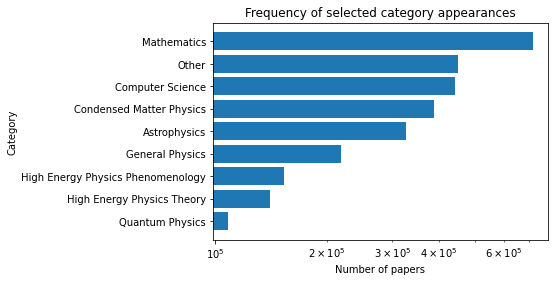

In [8]:
# All categories 
categories = [i for l in [x.split(' ') for x in df['categories']] for i in l]
Counter(categories).most_common(30)

def find_selected_category(category):
    for cat, _, label in selected_categories:
        if cat in category:
            return label
    return "Other"
selected_topics = []
for cat in categories:
    topic = find_selected_category(cat)
    selected_topics.append(topic)

number_of_topics = Counter(selected_topics).most_common()
labels_numbers = list(zip(*number_of_topics))
fig, ax = plt.subplots()
ax.barh(-np.arange(len(number_of_topics)), labels_numbers[1], tick_label=labels_numbers[0])
ax.set_xscale("log")
plt.title("Frequency of selected category appearances")
plt.xlabel("Number of papers")
plt.ylabel("Category")
plt.show()

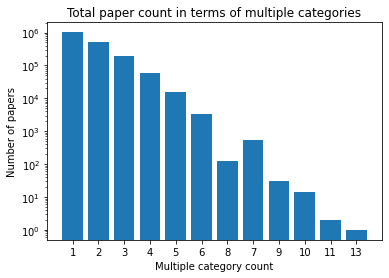

In [9]:
# Count of multiple categories in each paper
multi_categories = Counter([len(x.split(" ")) for x in df["categories"]])

fig, ax = plt.subplots()
ax.bar(np.arange(len(multi_categories)),multi_categories.values(), tick_label=list(multi_categories.keys()))
ax.set_yscale("log")
plt.title("Total paper count in terms of multiple categories")
plt.xlabel("Multiple category count")
plt.ylabel("Number of papers")
plt.show()

In [10]:
category_interaction_dic = {}
for m_cats in df.categories:
    m_cats_arr = m_cats.split(" ")
    for i, cat in enumerate(m_cats_arr):
        if cat not in category_interaction_dic:
            category_interaction_dic[cat] = {}
        for cat_it in m_cats_arr[i+1:]:
            if cat_it not in category_interaction_dic[cat]:
                category_interaction_dic[cat][cat_it] = {"weight": 1}
            else:
                category_interaction_dic[cat][cat_it]["weight"] += 1

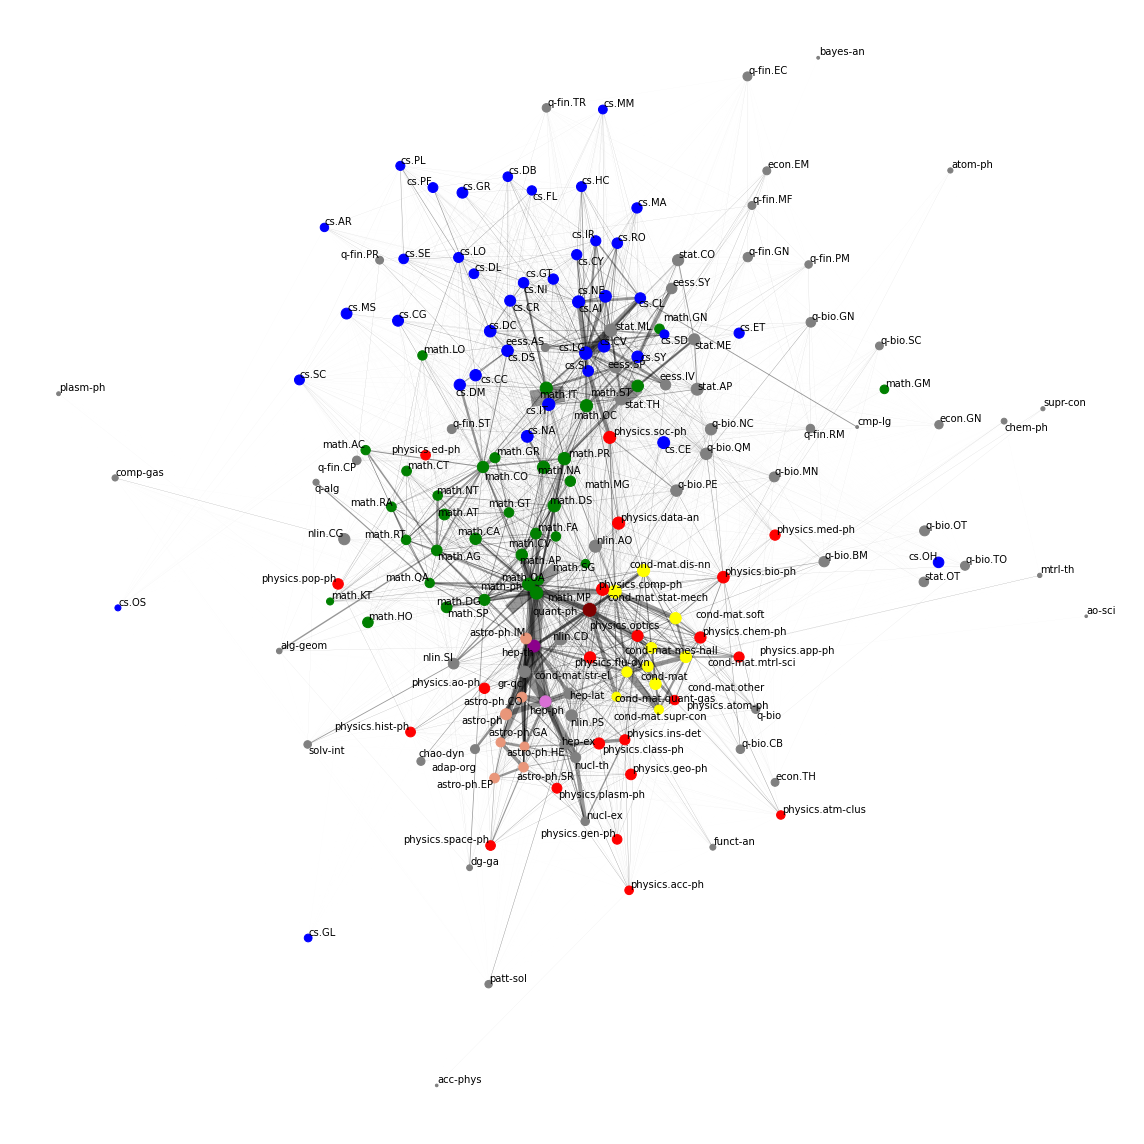

In [11]:
default_color = "grey"

def category_color(category):
    for keyword, color, _ in selected_categories:
        if keyword in category:
            return color
    return default_color

graph = nx.Graph(category_interaction_dic)

plt.figure(figsize=(16, 16))
  
node_size = [1.0 * graph.degree(v) for v in graph]

edge_weights = 0.001 * np.array([graph[u][v]["weight"] for u, v in graph.edges()])

node_color = list(map(category_color, graph))

pos = nx.spring_layout(graph, seed=1, k=3)
nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color)
labels = nx.draw_networkx_labels(graph, pos, font_size=10)
nx.draw_networkx_edges(graph, pos, width=edge_weights, edge_color="black", alpha=0.4)

adjust_text(labels.values(), lim=3)

plt.axis("off")
plt.tight_layout()
plt.show()

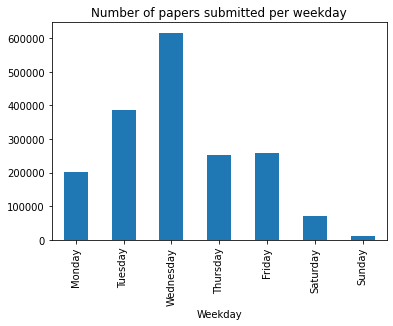

In [12]:
df.groupby(df.update_date.dt.weekday).title.count().sort_index().plot.bar()
plt.title("Number of papers submitted per weekday")
plt.xlabel("Weekday")
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda wd, p: calendar.day_name[wd]))
plt.show()

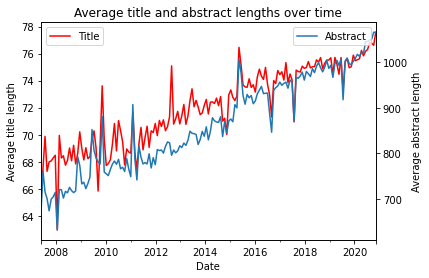

In [13]:
agg_lengths = df.assign(title_len=df.title.str.len(), abstract_len=df.abstract.str.len()) \
                .groupby(grouper_month).mean()
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
agg_lengths.title_len.plot(ax=ax0, color="red", label="Title")
agg_lengths.abstract_len.plot(ax=ax1, label="Abstract")
ax0.legend(loc=0)
ax0.set_ylabel("Average title length")
ax1.legend(loc=1)
ax1.set_ylabel("Average abstract length")
plt.title("Average title and abstract lengths over time")
ax0.set_xlabel("Date")
plt.show()

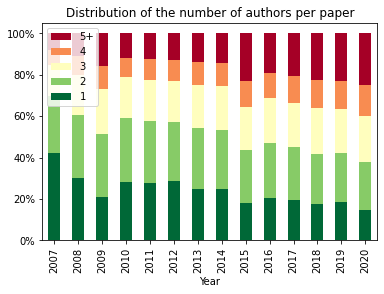

In [14]:
agg_authors = df[["update_date"]].assign(authors_len=df.authors_parsed.str.len())
agg_authors = agg_authors[agg_authors.authors_len > 0]
authors_buckets = 5
for i in range(1, authors_buckets):
    agg_authors[i] = agg_authors.authors_len == (i)
agg_authors["%s+" % authors_buckets] = agg_authors.authors_len >= authors_buckets
del agg_authors["authors_len"]
agg_authors_cat = agg_authors.groupby(grouper_year).mean()

agg_authors_cat.plot.bar(stacked=True, colormap="RdYlGn_r")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(agg_authors_cat.index.strftime("%Y")))
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], loc="upper left")
plt.xlabel("Year")
plt.title("Distribution of the number of authors per paper")
plt.show()

In [15]:
# We compute a low-dimensionality representation of the abstracts

vectorizer = TfidfVectorizer(stop_words="english")
abstracts_sparse = vectorizer.fit_transform(df.abstract)

n_components = 10

svd = TruncatedSVD(n_components=n_components, random_state=1)
abstracts_svd = svd.fit_transform(abstracts_sparse)

print(abstracts_sparse.shape)
print(abstracts_svd.shape)

(1796911, 579938)
(1796911, 10)


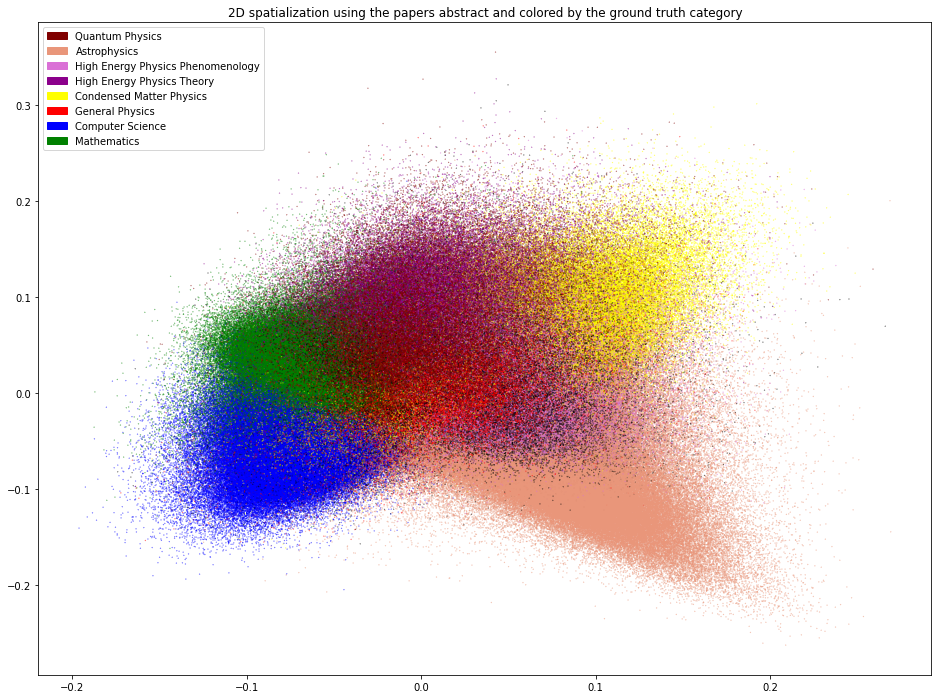

In [16]:
abstracts_2d = PCA(n_components=2).fit_transform(abstracts_svd)

default_color = "black"

plt.figure(figsize=(16, 12))
plt.legend(handles=[matplotlib.patches.Patch(color=color, label=label) for _, color, label in selected_categories])
plt.scatter(abstracts_2d[:, 0], abstracts_2d[:, 1], s=0.05, c=df.categories.apply(category_color))
plt.title("2D spatialization using the papers abstract and colored by the ground truth category")
plt.show()

In [17]:
# Associate each vectorized word to their score
words_labels = np.array(vectorizer.get_feature_names())
words_scores = np.squeeze(np.asarray(abstracts_sparse.sum(axis=0)))

words = pd.DataFrame({"word": words_labels, "score": words_scores})
words = words.sort_values(by="score", ascending=False)
words.head(15)

,word,score
359660,model,27499.299853
441654,quantum,22157.748556
228886,field,21172.039812
456491,results,20397.079840
175950,data,19927.617930
527564,time,19637.558680
210655,energy,18887.776836
524517,theory,18708.042992
549063,using,18411.302283
384122,non,17042.250573


In [18]:
# We extract topics in an unsupervised manner
# The number of documents needs to be reduced for it to terminate in reasonable time
# The number of topics has to be statically defined
n_documents_nmf = 25000
n_topics = 16
abstracts_nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init="nndsvd").fit(abstracts_sparse[:n_documents_nmf])

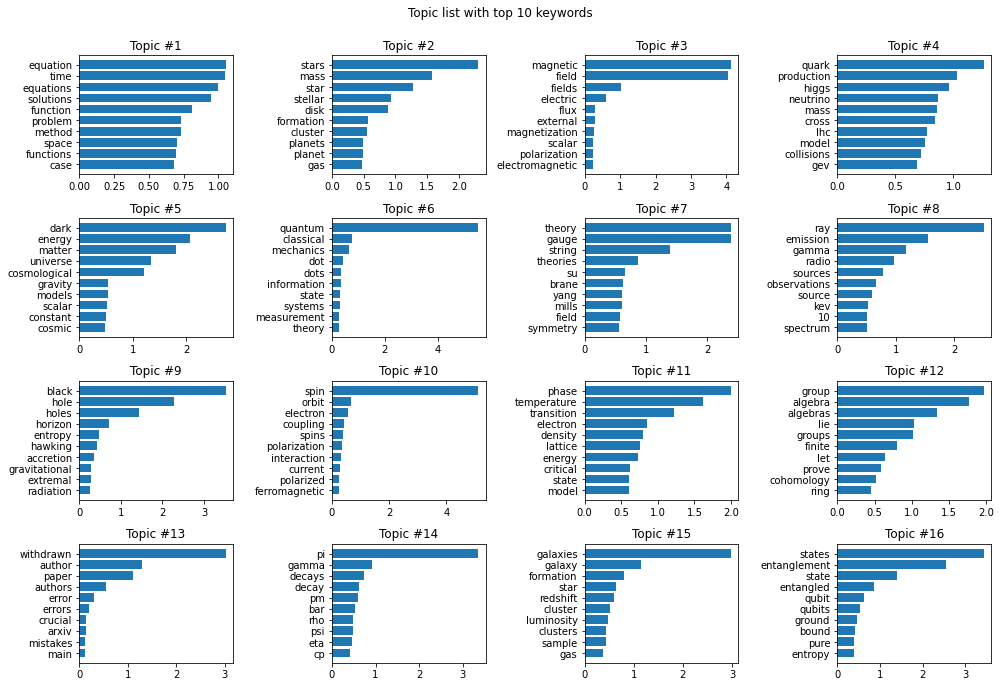

In [19]:
n_top_words = 10
plt.figure(figsize=(14, 10))
for i, topic in enumerate(abstracts_nmf.components_):
    topic_words_indices = topic.argsort()[:-n_top_words-1:-1]
    topic_words_labels = [words_labels[i] for i in topic_words_indices]
    topic_words_weights = [topic[i] for i in topic_words_indices]
    plt.subplot(4, 4, i + 1)
    ax = plt.gca()
    yticks = np.arange(n_top_words)[::-1]
    ax.barh(yticks, topic_words_weights)
    ax.set_yticks(yticks)
    ax.set_yticklabels(topic_words_labels)
    plt.title("Topic #%s" % (i + 1))
plt.gcf().tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Topic list with top %s keywords" % n_top_words)
plt.show()

In [20]:
# We try to find the best matching articles for a given keyword query
# Equivalently, this can be used to find similar articles

n_best_matches = 5

query = ["np", "complexity", "class"]
query_vector = vectorizer.transform(query)
cosine_similarities = np.amax(cosine_similarity(abstracts_sparse, query_vector), axis=1)
best_matches_indices = np.argsort(cosine_similarities, axis=0)[:-n_best_matches-1:-1]

df.iloc[best_matches_indices] \
    .assign(similarity=pd.Series(index=df.index[best_matches_indices], data=np.take(cosine_similarities, best_matches_indices)))

,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,similarity
id,,,,,,,,,,,,,,
cs/0511085,Ron Cohen,R. A. Cohen,Proving that P is not equal to NP and that P i...,9 pages ; 3 figures,None,None,None,cs.CC,None,"The open question, P=NP?, was presented by C...","[{'version': 'v1', 'created': 'Fri, 25 Nov 200...",2007-05-23,"[[Cohen, R. A., ]]",0.818074
math/0305445,Vinay Deolalikar,Vinay Deolalikar,On the questions P ?= NP $\cap$ co-NP and NP ?...,9 pages,None,None,None,math.LO,None,Schindler recently addressed two versions of...,"[{'version': 'v1', 'created': 'Fri, 30 May 200...",2007-05-23,"[[Deolalikar, Vinay, ]]",0.811175
1807.10983,Lane A. Hemaspaandra,Lane A. Hemaspaandra and Holger Spakowski,Team Diagonalization,None,None,None,None,cs.CC,http://arxiv.org/licenses/nonexclusive-distrib...,"Ten years ago, Gla{\ss}er, Pavan, Selman, an...","[{'version': 'v1', 'created': 'Sat, 28 Jul 201...",2018-07-31,"[[Hemaspaandra, Lane A., ], [Spakowski, Holger...",0.715374
cs/0406056,Selmer Bringsjord,Selmer Bringsjord and Joshua Taylor,P=NP,None,None,None,None,cs.CC cs.AI,None,We claim to resolve the P=?NP problem via a ...,"[{'version': 'v1', 'created': 'Mon, 28 Jun 200...",2007-05-23,"[[Bringsjord, Selmer, ], [Taylor, Joshua, ]]",0.697682
1011.2730,Frank Vega Delgado,Frank Vega Delgado,A Solution to the P versus NP Problem,Admin note: withdrawn by arXiv admin because o...,None,None,None,cs.CC,http://arxiv.org/licenses/nonexclusive-distrib...,The relationship between the complexity clas...,"[{'version': 'v1', 'created': 'Thu, 11 Nov 201...",2014-07-08,"[[Delgado, Frank Vega, ]]",0.681882
